#### Análise de Dados de Leilões da Sotheby's

Este projeto analisa um conjunto de dados de leilões de obras de arte da Sotheby's, explorando várias características como ano de criação, movimento artístico, condição da obra e preço. 

Vamos investigar como esses fatores influenciam o valor das obras e identificar tendências de mercado.

#### Importação de Bibliotecas e Configurações Iniciais

Primeiro, importamos as bibliotecas necessárias e configuramos o estilo dos gráficos.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#from genderize import Genderize
import numpy as np

# Configurações de estilo para os gráficos
#sns.set_theme(style="whitegrid")

In [2]:
# Caminho completo para o arquivo
path = r'C:\Users\pietr\sothebys_auction_price_classifier\sothebys_dataset.csv'

# Carregar o arquivo CSV
dataset = pd.read_csv(path)

In [3]:
# Obter informações gerais do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    754 non-null    int64 
 1   price         754 non-null    object
 2   artist        753 non-null    object
 3   title         754 non-null    object
 4   yearCreation  754 non-null    object
 5   signed        754 non-null    object
 6   condition     754 non-null    object
 7   period        754 non-null    object
 8   movement      754 non-null    object
dtypes: int64(1), object(8)
memory usage: 53.1+ KB


In [4]:
# Verificar valores ausentes
dataset.isnull().sum()

Unnamed: 0      0
price           0
artist          1
title           0
yearCreation    0
signed          0
condition       0
period          0
movement        0
dtype: int64

#### Pré-processamento dos Dados
- Limpeza da Coluna 'price'
- Removemos o texto "USD" e as vírgulas dos preços, convertendo-os para o tipo float.

In [5]:
# Converter a coluna 'price' para str, remover 'USD' e ',' e, em seguida, converter para float
dataset['price'] = dataset['price'].astype(str).str.replace(' USD', '').str.replace(',', '').astype(float)

dataset.sample(5)

Unnamed: 0    price            artist                     title  \
365         365   20.000  Hiroshi Sugimoto  Helicoid Minimal Surface   
89           89  800.000     Jean Tinguely              Amour Totale   
643         643  680.000     Tony Jannetti       The Third Emergence   
733         733    1.275      T. L. Solien            Blue Stem Land   
586         586  800.000        Karen Kunc            Current's Edge   

    yearCreation                                             signed  \
365         2004   Signed in front under the mat on the right side.   
89          1991                    Signed and numbered on the back   
643         1971  Signed in pencil Tony Jannetti '71 lower right...   
733         1986                                              [nan]   
586         1987   Signed, numbered and dated in pencil lower right   

                                             condition        period  \
365                               Excellent condition.  Contemporary   
89   This work is in excellent condition, direct fr...  Contemporary   
643  This work is in very good condition.Not examin...        Modern   
733  Not examined outside of frame.Pinholes to edge...  Contemporary   
586  This work is in very good condition.Not examin...      Post-War   

             movement  
365       Conceptual   
89   Nouveau Réalisme  
643          Abstract  
733          Abstract  
586          Abstract

Tratamento da Coluna 'yearCreation'
- Identificamos e tratamos valores não numéricos na coluna 'yearCreation'.

In [6]:
# Identificar entradas na coluna 'yearCreation' com valores não numéricos
non_numeric_years = dataset[~dataset['yearCreation'].astype(str).str.isnumeric()]
non_numeric_year_count = len(non_numeric_years)

# Exibir algumas entradas para analisar os valores não numéricos
print(f"Entradas com texto na coluna 'yearCreation': {non_numeric_year_count}")
print(non_numeric_years[['artist', 'title', 'yearCreation']].head(10))

Entradas com texto na coluna 'yearCreation': 105
                     artist                       title  \
1         Pavel Tchelitchew       Drawings of the Opera   
12                 Zhang Yu                      96.6.2   
25                Pat Steir        Hand Painted Lily #1   
33         Bernard Taurelle        Jeune Fille Songeuse   
34             Louis Fabien             Coupe et Fruits   
35         Bernard Taurelle                  Le Gouter    
37       James A. Fetherolf  Agathlan (Monument Valley)   
38  Julia Noffsinger Rogers               Dappled Light   
39  Julia Noffsinger Rogers   Breeze Through the Grass    
40            Grant Hacking              From Hal's Eye   

                 yearCreation  
1    First Half 20th Century   
12                      [nan]  
25                1992 - 2004  
33          Mid 20th Century   
34          Mid 20th Century   
35          Mid 20th Century   
37  Second Half 20th Century   
38  Second Half 20th Century   
39  Second Ha

In [7]:
# Preencher valores nulos em 'yearCreation' com 'Unknown' temporariamente para evitar problemas no processamento
dataset['yearCreation'] = dataset['yearCreation'].fillna('Unknown')

# Substituir valores textuais específicos por anos aproximados em 'yearCreation'
dataset['yearCreation'] = dataset['yearCreation'].replace({
    'Late 20th Century': '1970',
    'Second Half 20th Century': '1975',
    'Circa 1970': '1970',
    'First Half 20th Century': '1950',
    'Early 20th Century': '1920',
    'Mid 20th Century': '1955',
    '3D printed using ABS, PLA plastics, resin, automobile paints, etched brass, dry transfers, acrylic mirror, batik fabric, quartz clock': 'Unknown',
    'Late 19th Century': '1890',
    'Second Half 19th Century': '1875',
    'Circa 1970 - 1979': '1975',
    'Circa 1980': '1980',
    'Circa 1991': '1991',
    'Circa 2001': '2001',
    'Circa 1987': '1987',
    'Circa 1989': '1989',
    'Circa 1930 - 1939': '1935',  # Centraliza o intervalo
    '1990 - 1999': '1995',        # Centraliza o intervalo
    '1911 - 1915': '1913',        # Centraliza o intervalo
    'First Half 20th Century ': '1950',
    'Second Half 20th Century ': '1975',
    'Late 20th Century ': '1970',
    'Mid 20th Century ': '1955',
    '19th Century ': '1850',
    '20th Century ': '1900',
    '21st Century ': '2000',
    'Early 20th Century ': '1920',
})

# Remover o termo 'Circa' e manter apenas o ano aproximado
dataset['yearCreation'] = dataset['yearCreation'].str.replace(r'Circa (\d+)', r'\1', regex=True)

# Atribuir valores médios de ano com base no período, para onde o valor é 'Unknown'
period_year_map = {
    'Post-War': '1950',
    'Contemporary': '2000',
    'Modern': '1930',
    '19th Century': '1850',
}

# Substituir valores 'Unknown' com base no período
dataset.loc[dataset['yearCreation'] == 'Unknown', 'yearCreation'] = dataset['period'].map(period_year_map).fillna('Unknown')

# Corrigir anos não padronizados, como '1961, printed in 2010', '1992 - 2004', e similares
dataset['yearCreation'] = dataset['yearCreation'].str.extract(r'(\d{4})').fillna(dataset['yearCreation'])

# Verificar as entradas únicas para confirmar as substituições
print(dataset['yearCreation'].unique())

# Exibir algumas linhas com valores ainda não padronizados para verificar
remaining_non_standard_years = dataset[dataset['yearCreation'].str.contains('Unknown|^Circa|^Late|^Early', regex=True)]
print(remaining_non_standard_years[['artist', 'title', 'yearCreation']].head(10))


['2021' '1950' '2016' '2010' '2001' '1977' '2007' '1993' '2014' '1973'
 '2008' '2015' '2012' '2002' '1992' '2020' '1991' '2018' '1920' '1955'
 '1975' '2003' '2000' '2005' '1999' '1958' '1850' '1877' '2004' '2013'
 '2006' '1990' '1925' '1935' '1928' '2022' '1961' '1994' '1996' '2017'
 '2019' '2011' '1948' '1971' '1960' '1972' '1984' '1970' '1981' '1976'
 '1896' '1965' '1968' '1969' '1998' '1940' '1988' '1892' '1947' '1995'
 '1980' '1997' '1983' '1959' '1939' '1964' '1952' '1930' '1949' '1978'
 '1957' '2009' '1900' '1962' '1986' '1985' '1967' '1974' '1989' '1890'
 '1894' '1941' '1936' '1953' '1943' '1946' '1937' '1944' '1913' '1921'
 '1987' '1979' '1982' '1931' '1954']
Empty DataFrame
Columns: [artist, title, yearCreation]
Index: []


In [8]:
dataset.sample(5)

Unnamed: 0  price            artist                              title  \
546         546  800.0    Joseph Soloman                       Garden Scene   
742         742  680.0  Yasuyuki Shibata                            Satsuma   
217         217    5.0        Mike Reesé             Greed Sweet Like Candy   
362         362   37.0        Marcel Dyf                  Fille aux Violets   
94           94   42.5    Cindy  Sherman  Madame de Pompadour (née Poisson)   

    yearCreation                                             signed  \
546         1979  Inscribed Joseph Soloman 79 bottom right corne...   
742         2011                   Signed and dated on lower right.   
217         2021                   Signed and titled on the reverse   
362         1957                    Signed Dyf bottom left in paint   
94          1990                                Signed and numbered   

                                             condition        period  \
546  This work is in very good condition.Not examin...      Post-War   
742  Not examined out of frame.No obvious signs of ...  Contemporary   
217                               Excellent condition.  Contemporary   
362  Overall very good condition.Small chip to canv...      Post-War   
94   This work is in excellent condition, direct fr...  Contemporary   

                  movement  
546          Expressionism  
742  Geometric Abstraction  
217                Pop Art  
362          Impressionism  
94             Conceptual

In [9]:
# Exemplo: Preencher valores nulos em 'condition' com 'Desconhecido'
dataset['condition'] = dataset['condition'].fillna('Unknown')

# Verificar novamente se ainda restam valores nulos
dataset.isnull().sum()

dataset['artist'] == '[nan]'

0      False
1      False
2      False
3      False
4      False
       ...  
749    False
750    False
751    False
752    False
753    False
Name: artist, Length: 754, dtype: bool

In [10]:
# Estatísticas descritivas para a coluna de preço
dataset['price'].describe

<bound method NDFrame.describe of 0       28.500
1        3.000
2        5.000
3        5.000
4        2.500
        ...   
749    680.000
750      1.275
751    680.000
752      1.275
753    680.000
Name: price, Length: 754, dtype: float64>

C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\763214166.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


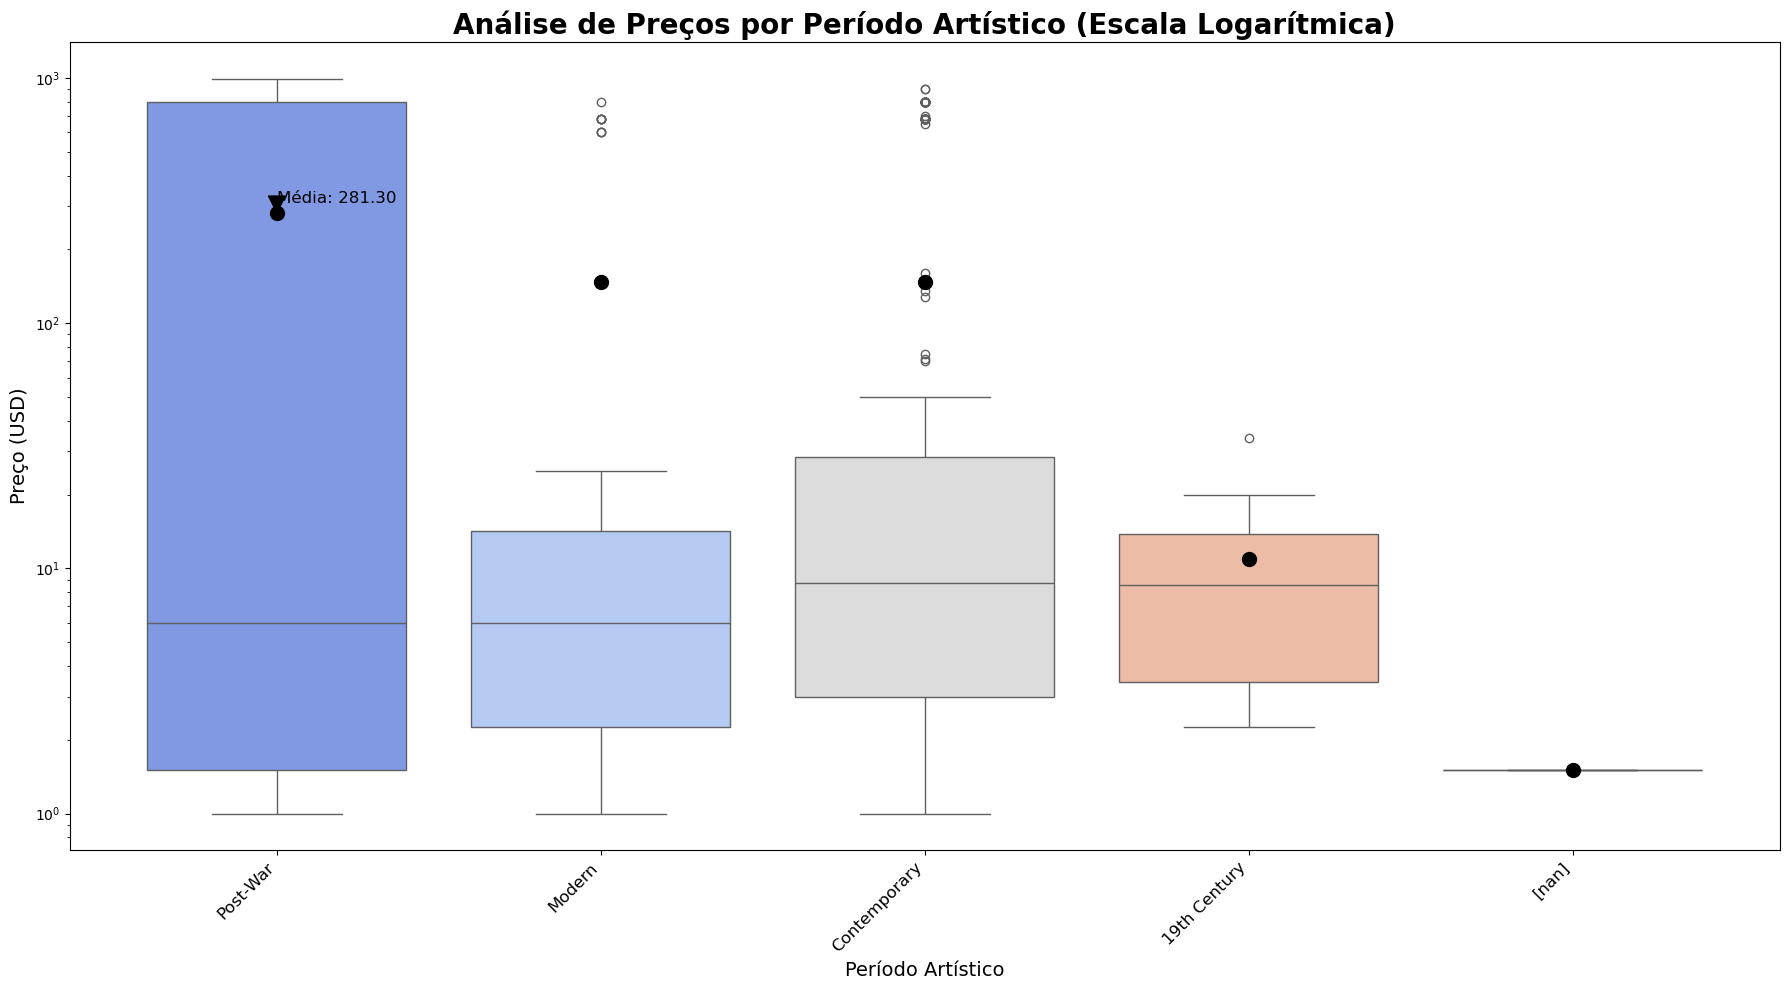

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Certifique-se de que a biblioteca pandas está importada e que 'dataset' está definido.

# Filtrar o dataset para remover valores nulos na coluna 'period'
filtered_data = dataset.dropna(subset=['period'])

# Ordenar os períodos artísticos pelo preço médio em ordem decrescente
period_order = filtered_data.groupby('period')['price'].mean().sort_values(ascending=False).index

# Configurações iniciais para o gráfico
plt.figure(figsize=(18, 10))

# Criar boxplot com ordem personalizada e paleta de cores
sns.boxplot(
    data=filtered_data,
    x='period',
    y='price',
    order=period_order,
    palette='coolwarm'
)

# Adicionar linhas representando o preço médio para cada período
for period in period_order:
    mean_price = filtered_data[filtered_data['period'] == period]['price'].mean()
    plt.scatter(x=period, y=mean_price, color='black', label='_nolegend_', zorder=5, s=100)
    # Adicionar rótulo apenas para o primeiro período para evitar sobreposição
    if period == period_order[0]:
        plt.annotate(f'Média: {mean_price:.2f}', xy=(period, mean_price), xytext=(period, mean_price * 1.1),
                     arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Configurar escala logarítmica para o eixo Y
plt.yscale('log')

# Personalizações do gráfico
plt.title('Análise de Preços por Período Artístico (Escala Logarítmica)', fontsize=20, fontweight='bold')
plt.xlabel('Período Artístico', fontsize=14)
plt.ylabel('Preço (USD)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Exibir o gráfico
plt.show()


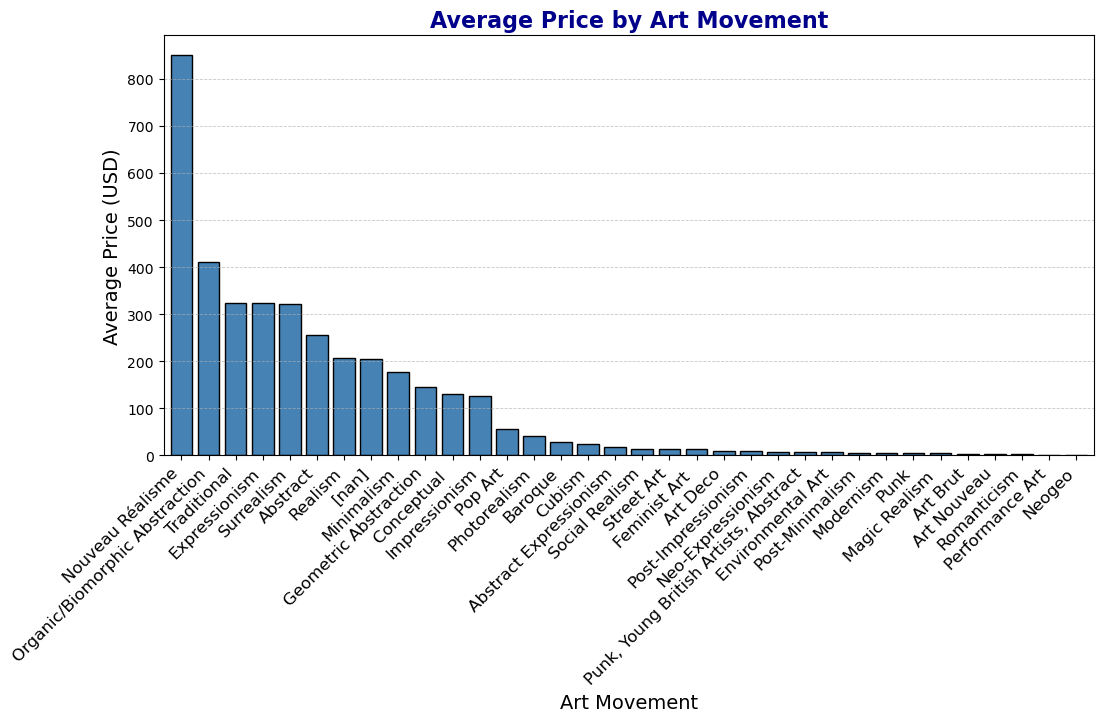

In [12]:
# Calculate the average price per artistic movement
preco_por_movimento = dataset.groupby('movement')['price'].mean().sort_values(ascending=False)

# Set up the plot with slightly larger dimensions
plt.figure(figsize=(12, 6))
barplot = preco_por_movimento.plot(
    kind='bar', 
    color='steelblue', 
    edgecolor='black',
    width=0.8
)

# Add title and axis labels with enhanced styling
plt.title('Average Price by Art Movement', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Art Movement', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Average Price (USD)', fontsize=14, fontweight='medium', color='black')


# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add gridlines for easier visual comparison
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)

# Use subplots_adjust to increase space at the top and bottom
plt.subplots_adjust(top=0.9, bottom=0.2)

# Display the plot
plt.show()


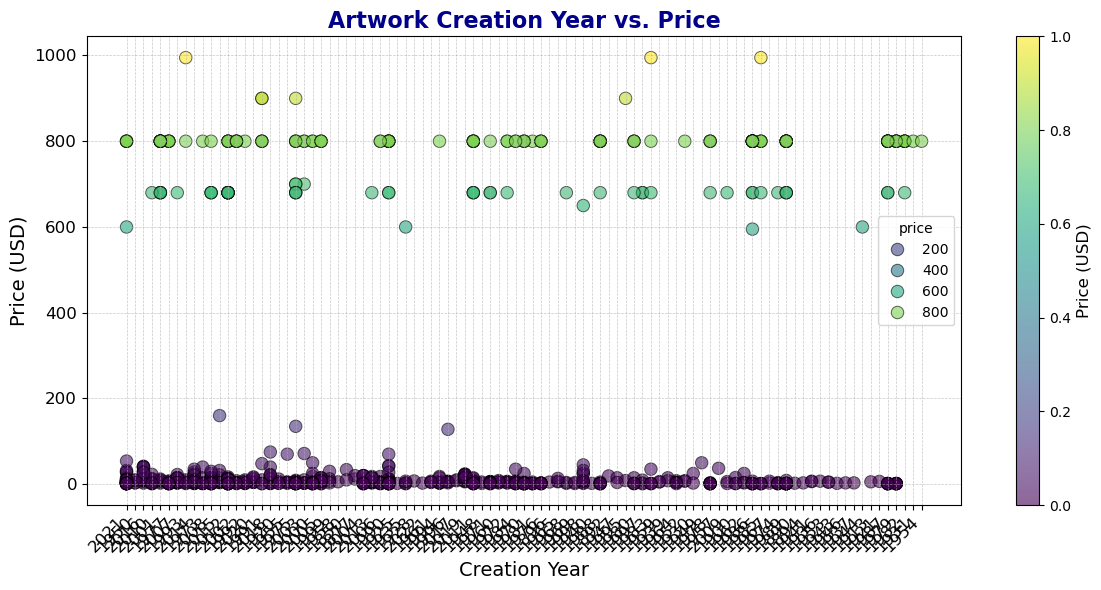

In [13]:
# fazer uma analise, obras muito autocusto, caras, medias, baixas (classe para os valores)

# Scatter plot of creation year versus price with enhanced visualization
plt.figure(figsize=(12, 6))  # Increased size for detailed view

# Plot scatter plot with color map for better insight on price distribution
scatter = sns.scatterplot(
    data=dataset,
    x='yearCreation',
    y='price',
    hue='price',  # Add a color gradient based on price
    palette='viridis',
    s=80,  # Adjust marker size for optimal visibility
    edgecolor='black',
    alpha=0.6,
    marker='o' # mudar os formatos
)

# Customize title and axis labels
plt.title('Artwork Creation Year vs. Price', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Creation Year', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Price (USD)', fontsize=14, fontweight='medium', color='black')

# Add a color bar to represent price range
cbar = plt.colorbar(scatter.collections[0], ax=scatter, orientation="vertical")
cbar.set_label('Price (USD)', fontsize=12, color='black')

# Add gridlines for better readability
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Format axis ticks
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Improve layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()



In [14]:
#nao tem uma relacao

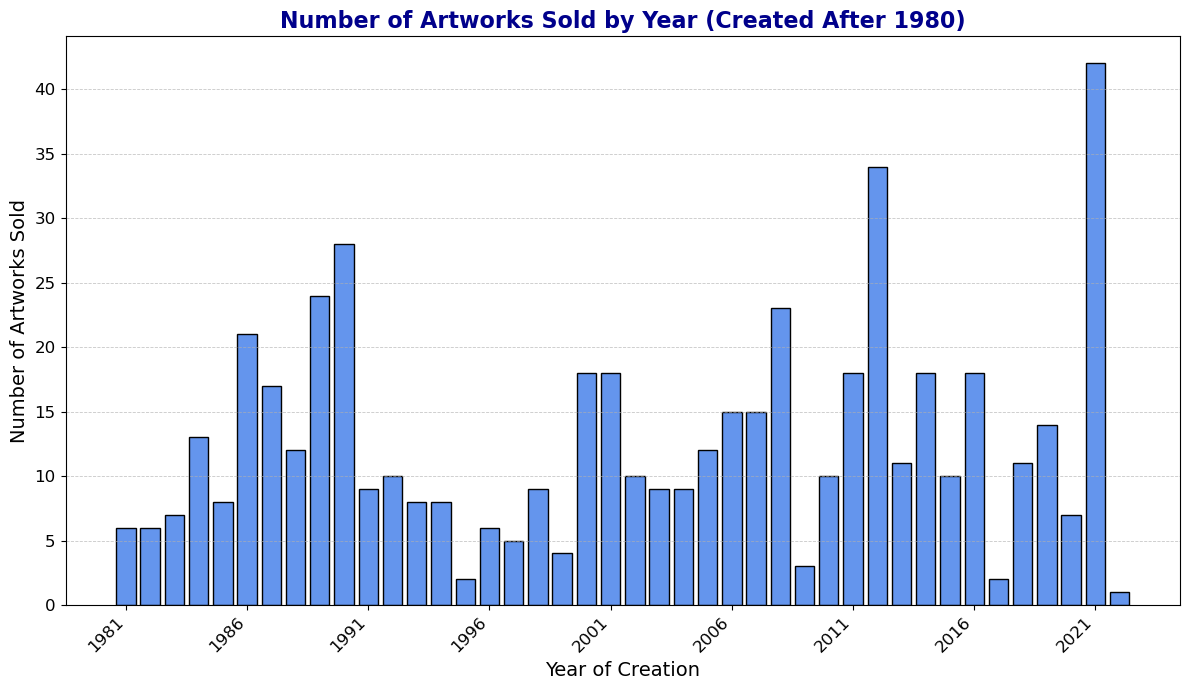

In [15]:
# Ensure 'yearCreation' is in integer format
dataset['yearCreation'] = pd.to_numeric(dataset['yearCreation'], errors='coerce')

# Filter for artworks created after 1980
after_1980 = dataset[dataset['yearCreation'] > 1980]

# Drop rows with NaN values in 'yearCreation' (if any were created by 'coerce' conversion)
after_1980 = after_1980.dropna(subset=['yearCreation'])

# Calculate the number of works sold by year
sold_by_year = after_1980['yearCreation'].value_counts().sort_index()

# Create the bar plot with enhanced formatting
plt.figure(figsize=(12, 7))
plt.bar(
    sold_by_year.index, 
    sold_by_year.values, 
    color='cornflowerblue', 
    edgecolor='black', 
    width=0.8
)

# Add title and axis labels with enhanced styling
plt.title('Number of Artworks Sold by Year (Created After 1980)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Year of Creation', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Number of Artworks Sold', fontsize=14, fontweight='medium', color='black')

# Add gridlines for easier reading
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)

# Format x-axis ticks for better readability
plt.xticks(ticks=range(int(after_1980['yearCreation'].min()), int(after_1980['yearCreation'].max()) + 1, 5), 
           rotation=45, ha='right', fontsize=12)

# Format y-axis ticks
plt.yticks(fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


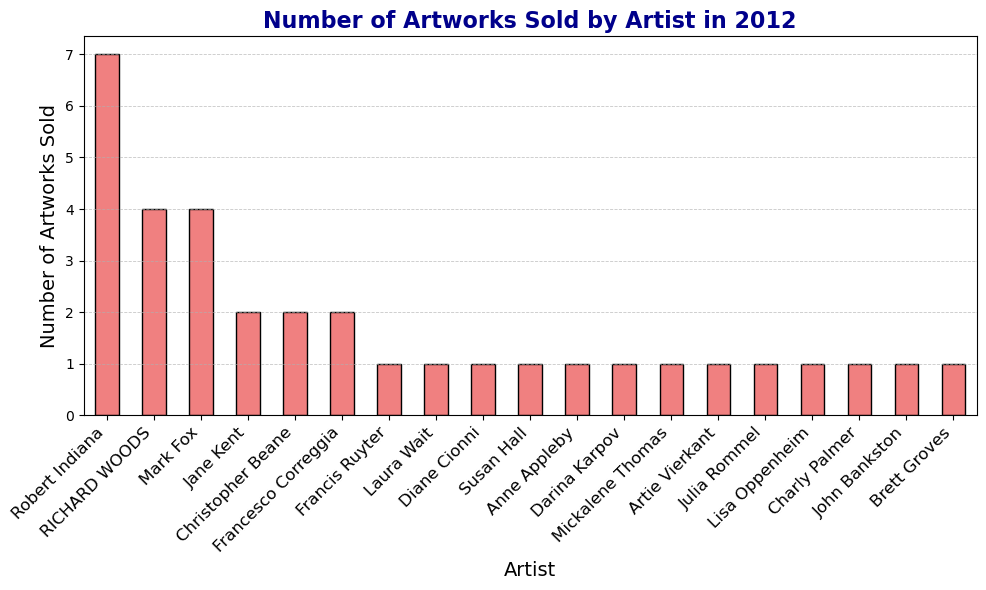

In [16]:
# Filter for artworks created after 1980 and sold in 2012
sold_2012 = after_1980[after_1980['yearCreation'] == 2012]

# Count the number of works sold by each artist in 2012
artists_2012 = sold_2012['artist'].value_counts()

# Display the artists and the number of artworks sold
plt.figure(figsize=(10, 6))
artists_2012.plot(
    kind='bar',
    color='lightcoral',
    edgecolor='black'
)

# Add title and axis labels with styling
plt.title('Number of Artworks Sold by Artist in 2012', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Number of Artworks Sold', fontsize=14, fontweight='medium', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add gridlines for easier interpretation
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


In [17]:
# Filtrar apenas as obras criadas após o ano 2000
after_1980 = dataset[dataset['yearCreation'] > 1980]

# Contar o número de obras vendidas para cada artista após 2000
top_artists_after_1980 = after_1980['artist'].value_counts().head(10)

# Exibir os artistas mais vendidos e o número de obras vendidas
print("Artistas mais vendidos (obras criadas após 1980):")
print(top_artists_after_1980)


Artistas mais vendidos (obras criadas após 1980):
artist
Russell Young         17
Donald Sultan          9
Ed  Ruscha             7
Cindy  Sherman         7
Robert Indiana         7
Doris McCarthy         6
Hossein Edalatkhah     6
John Baldessari        6
John Fischer           6
Takashi Murakami       5
Name: count, dtype: int64


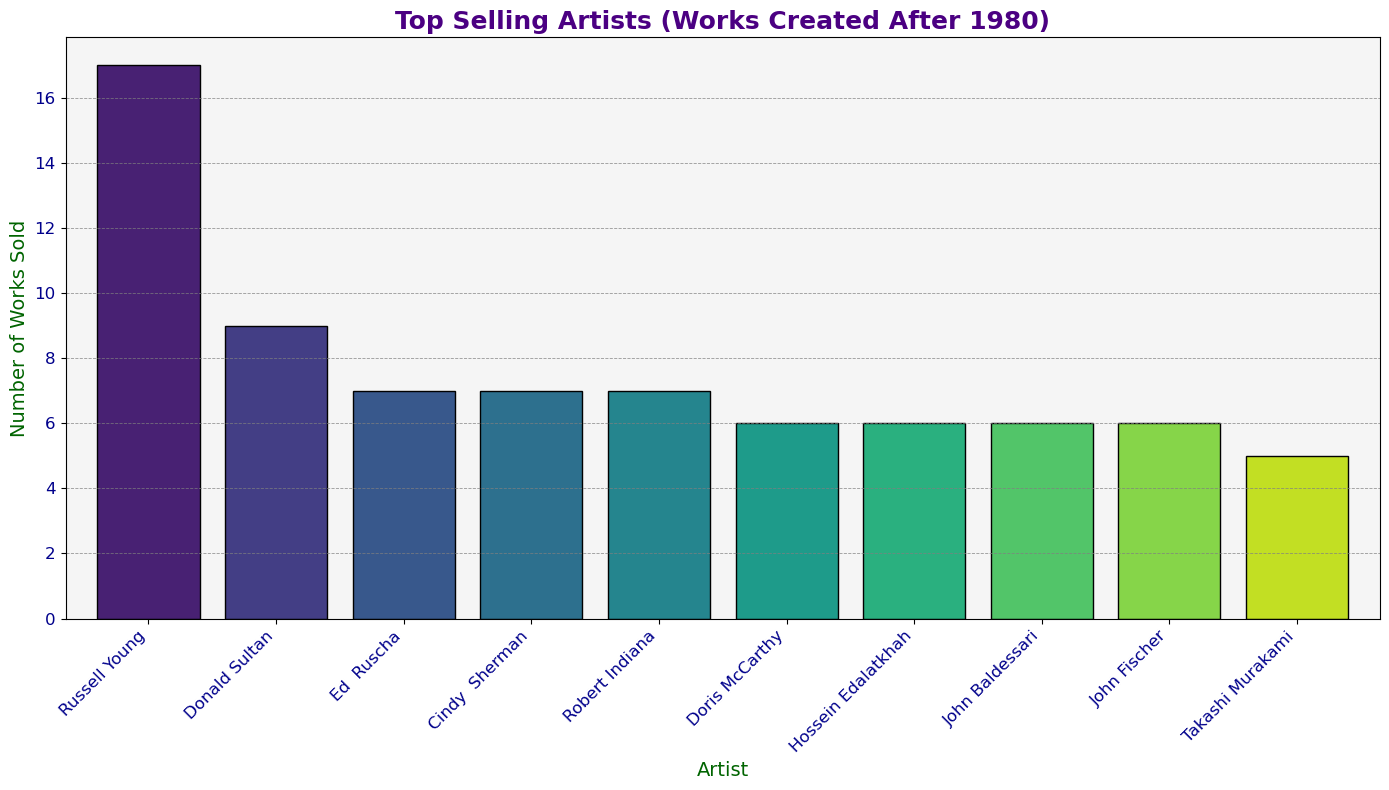

In [18]:

# Creating a bar plot for the top-selling artists (works created after 1980)
plt.figure(figsize=(14, 8))

# Choosing a color palette
colors = sns.color_palette("viridis", len(top_artists_after_1980))

# Plotting with enhanced colors
top_artists_after_1980.plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    width=0.8
)

# Adding title and labels with enhanced styling
plt.title(
    'Top Selling Artists (Works Created After 1980)', 
    fontsize=18, fontweight='bold', color='indigo'
)
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='darkgreen')
plt.ylabel('Number of Works Sold', fontsize=14, fontweight='medium', color='darkgreen')

# Rotating x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=12, color='darkblue')
plt.yticks(fontsize=12, color='darkblue')

# Adding subtle background color
plt.gca().set_facecolor('#f5f5f5')

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.8, color='gray')

# Adjusting layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()

Total Sales Value of the Top 10 Selling Artists (Works Created After 1980):
artist
T.L. Solien         4001.5
Steven Sorman       3200.0
Mark Fox            2720.0
Jane Kent           2720.0
Marcia Scanlon      2401.5
Gregory Crane       2400.0
Susana Solano       2400.0
Stephanie Snider    2400.0
MICHAEL MAZUR       2400.0
Kate Whiteford      2400.0
Name: price, dtype: float64


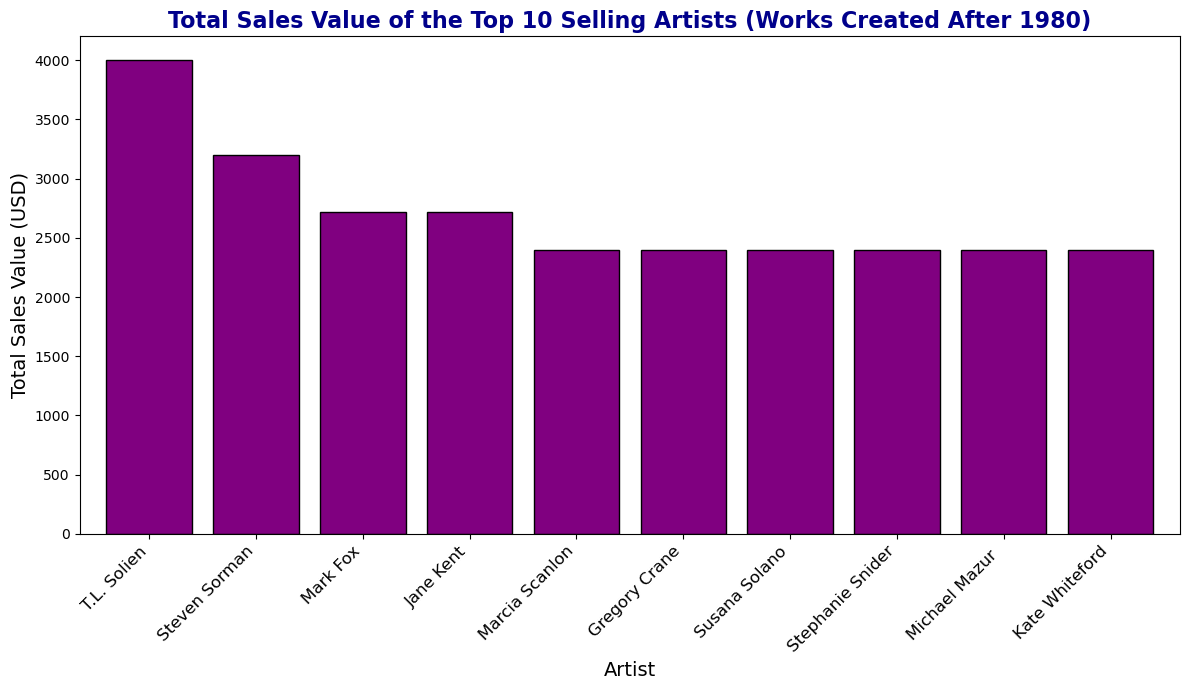

In [19]:

# Agrupando os dados por artista e somando os valores de vendas
total_sales_per_artist = dataset.groupby('artist')['price'].sum()

# Ordenando os artistas pelo valor total de vendas em ordem decrescente
top_10_sales_artists = total_sales_per_artist.sort_values(ascending=False).head(10)

# Display the total sales value for the top 10 selling artists
print("Total Sales Value of the Top 10 Selling Artists (Works Created After 1980):")
print(top_10_sales_artists)

# Supondo que os dados estejam em um Pandas Series chamado 'top_10_sales_artists'

# Função para padronizar os nomes
def format_name(name):
    if name.isupper():  # Verifica se o nome está todo em letras maiúsculas
        return name.title()  # Converte para formato Title Case
    return name  # Retorna o nome original se já estiver no formato correto

# Aplicando a função a todos os nomes
top_10_sales_artists.index = top_10_sales_artists.index.map(format_name)

# Recriando o gráfico com os nomes padronizados
plt.figure(figsize=(12, 7))
top_10_sales_artists.plot(kind='bar', color='purple', edgecolor='black', width=0.8)

plt.title('Total Sales Value of the Top 10 Selling Artists (Works Created After 1980)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Total Sales Value (USD)', fontsize=14, fontweight='medium', color='black')
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='medium')
plt.tight_layout()
plt.show()



Artists with the Most Expensive Works (Works Created Since 1990):
artist
Mary Frank            995.0
César                 900.0
Philip Read           900.0
Adrian Wiszniewski    800.0
Adrianne Wortzel      800.0
Anne Ross             800.0
Barbara Schwartz      800.0
Bill Jensen           800.0
Brett Groves          800.0
Brian O'Doherty       800.0
Name: price, dtype: float64


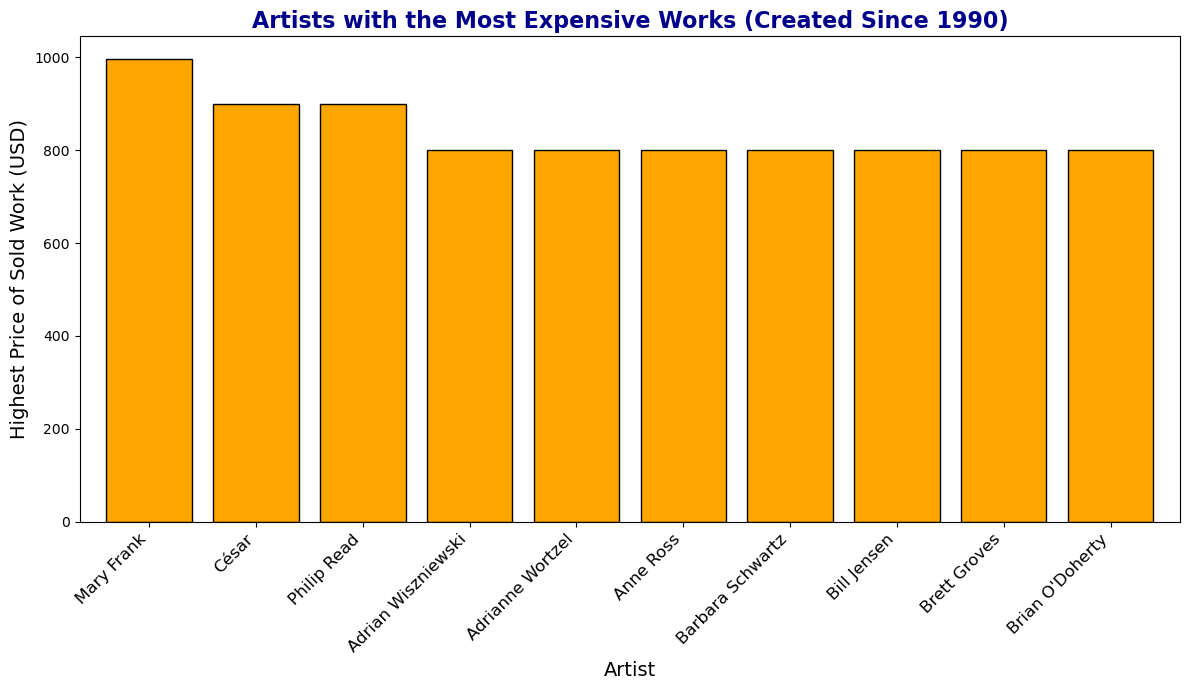

In [20]:
# Filter the dataset for works created from 1990 onwards
since_1990 = dataset[dataset['yearCreation'] >= 1990]

# For each artist, find the highest price of a work
highest_price_by_artist = since_1990.groupby('artist')['price'].max()

# Select the top 10 artists with the most expensive works
top_10_expensive_artists = highest_price_by_artist.nlargest(10)

# Display the artists with the most expensive works since 1990
print("Artists with the Most Expensive Works (Works Created Since 1990):")
print(top_10_expensive_artists)

# Create the bar plot for the top 10 expensive artists
plt.figure(figsize=(12, 7))  # Larger figure for better readability
top_10_expensive_artists.plot(kind='bar', color='orange', edgecolor='black', width=0.8)

# Customize the title and axis labels with enhanced styling
plt.title('Artists with the Most Expensive Works (Created Since 1990)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Highest Price of Sold Work (USD)', fontsize=14, fontweight='medium', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='medium')

# Improve the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


Artists with the Most Expensive Works (Works Created Since 1960):
artist
Fred Mitchell              995.0
Mariann Loveland-Miller    995.0
Mary Frank                 995.0
César                      900.0
Julia Noffsinger Rogers    900.0
Philip Read                900.0
Adrian Wiszniewski         800.0
Adrianne Wortzel           800.0
Agnes Story                800.0
Alan Herman                800.0
Name: price, dtype: float64


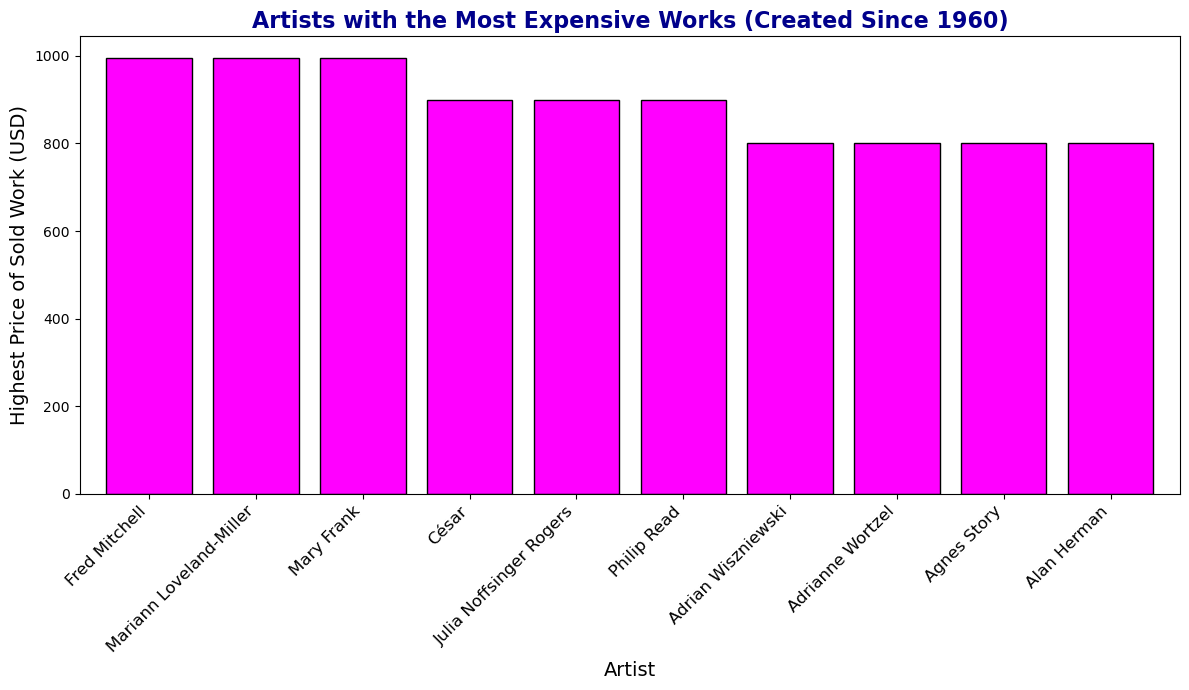

In [21]:
# Filter the dataset for works created from 1960 onwards
since_1960 = dataset[dataset['yearCreation'] >= 1960]

# For each artist, find the highest price of a work
highest_price_by_artist = since_1960.groupby('artist')['price'].max()

# Select the top 10 artists with the most expensive works
top_10_expensive_artists = highest_price_by_artist.nlargest(10)

# Display the artists with the most expensive works since 1960
print("Artists with the Most Expensive Works (Works Created Since 1960):")
print(top_10_expensive_artists)

# Create the bar plot for the top 10 expensive artists
plt.figure(figsize=(12, 7))  # Larger figure for better readability
top_10_expensive_artists.plot(kind='bar', color='magenta', edgecolor='black', width=0.8)

# Customize the title and axis labels with enhanced styling
plt.title('Artists with the Most Expensive Works (Created Since 1960)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Highest Price of Sold Work (USD)', fontsize=14, fontweight='medium', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='medium')

# Improve the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\2094912679.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contemporary_dataset['decade'] = (contemporary_dataset['yearCreation'] // 10) * 10


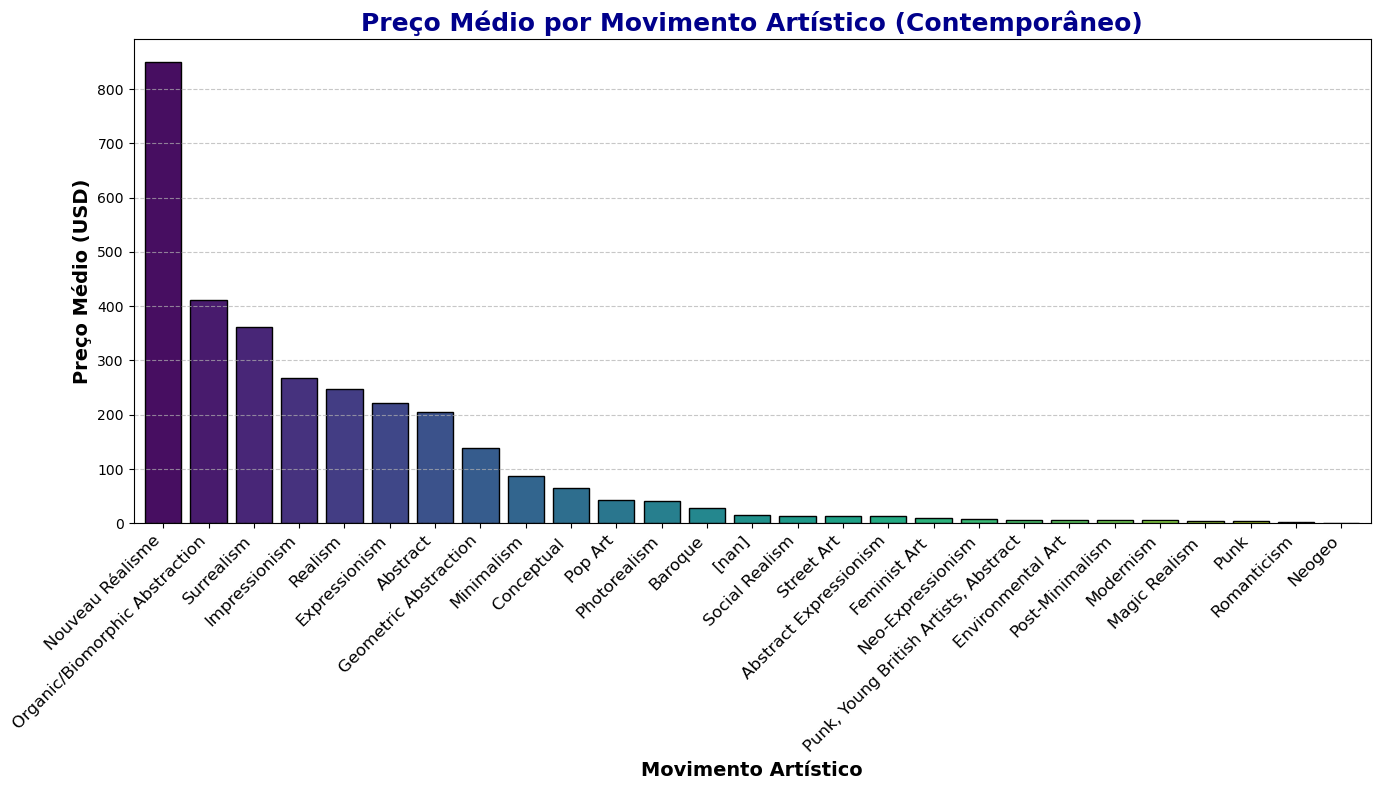

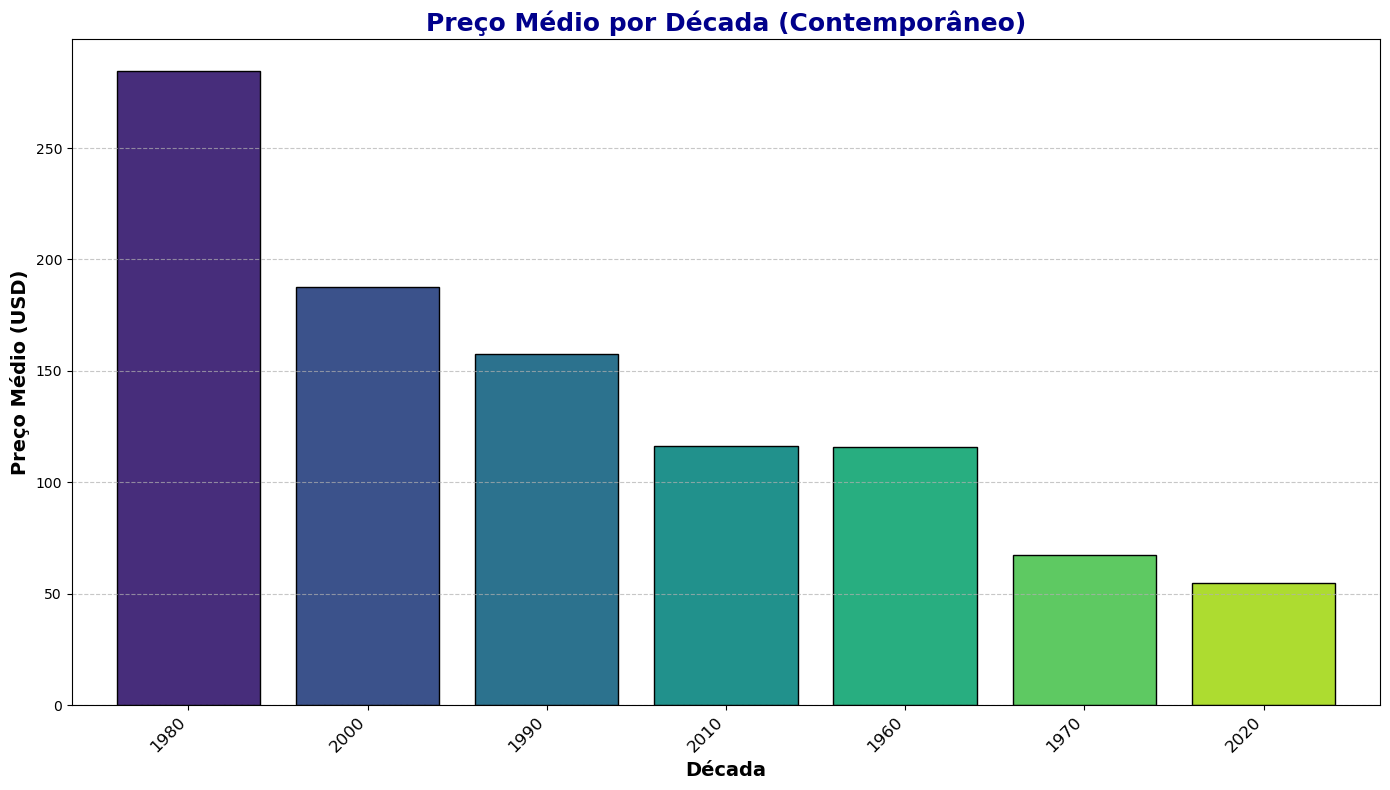

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrar o dataset para incluir apenas artistas contemporâneos
contemporary_dataset = dataset[dataset['period'] == 'Contemporary']

# Criar uma coluna para décadas (usando a coluna 'yearCreation')
contemporary_dataset['decade'] = (contemporary_dataset['yearCreation'] // 10) * 10

# Preço médio por movimento artístico para artistas contemporâneos
avg_price_by_movement_contemporary = (
    contemporary_dataset.groupby('movement')['price']
    .mean()
    .sort_values(ascending=False)
)

# Preço médio por década para artistas contemporâneos
avg_price_by_decade_contemporary = (
    contemporary_dataset.groupby('decade')['price']
    .mean()
    .sort_values(ascending=False)
)

# Função reutilizável para criar gráficos de barras
def plot_bar_chart(data, title, xlabel, ylabel, rotation=45):
    plt.figure(figsize=(14, 8))
    data.plot(
        kind='bar',
        color=sns.color_palette("viridis", len(data)),
        width=0.8,
        edgecolor='black',
    )
    
    # Adicionar título e rótulos
    plt.title(title, fontsize=18, fontweight='bold', color='darkblue')
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color='black')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color='black')
    
    # Personalizar os ticks
    plt.xticks(rotation=rotation, ha='right', fontsize=12, fontweight='medium')
    
    # Adicionar gridlines para melhorar a legibilidade
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

# Gráfico: Preço médio por movimento artístico
plot_bar_chart(
    avg_price_by_movement_contemporary,
    'Preço Médio por Movimento Artístico (Contemporâneo)',
    'Movimento Artístico',
    'Preço Médio (USD)',
)

# Gráfico: Preço médio por década
plot_bar_chart(
    avg_price_by_decade_contemporary,
    'Preço Médio por Década (Contemporâneo)',
    'Década',
    'Preço Médio (USD)',
)



In [23]:
# Filtrar o dataset para obras criadas a partir de 2021
since_2021 = dataset[dataset['yearCreation'] >= 2021]

# Para cada artista, encontrar o preço mais alto de uma obra
highest_price_by_artist = since_2021.groupby('artist')['price'].max()

# Selecionar os 10 artistas com as obras mais caras
top_10_expensive_artists = highest_price_by_artist.nlargest(10)

# Exibir os artistas com as obras mais caras desde 2021
print("Artistas com as obras mais caras (obras criadas desde 2021):")
print(top_10_expensive_artists)

Artistas com as obras mais caras (obras criadas desde 2021):
artist
Caren Canier          800.0
Marcia Scanlon        800.0
Sandra Clark          800.0
George Platt Lynes    600.0
Mario Schifano         54.0
Agnieszka  Pilat       32.0
Tommaso Ottieri        28.5
Zhang Yu               15.0
Amedeo Simonetti       12.0
Hossein Edalatkhah     10.0
Name: price, dtype: float64


C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\3330741416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_expensive_artists.index,
C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\3330741416.py:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=top_10_expensive_artists.index,


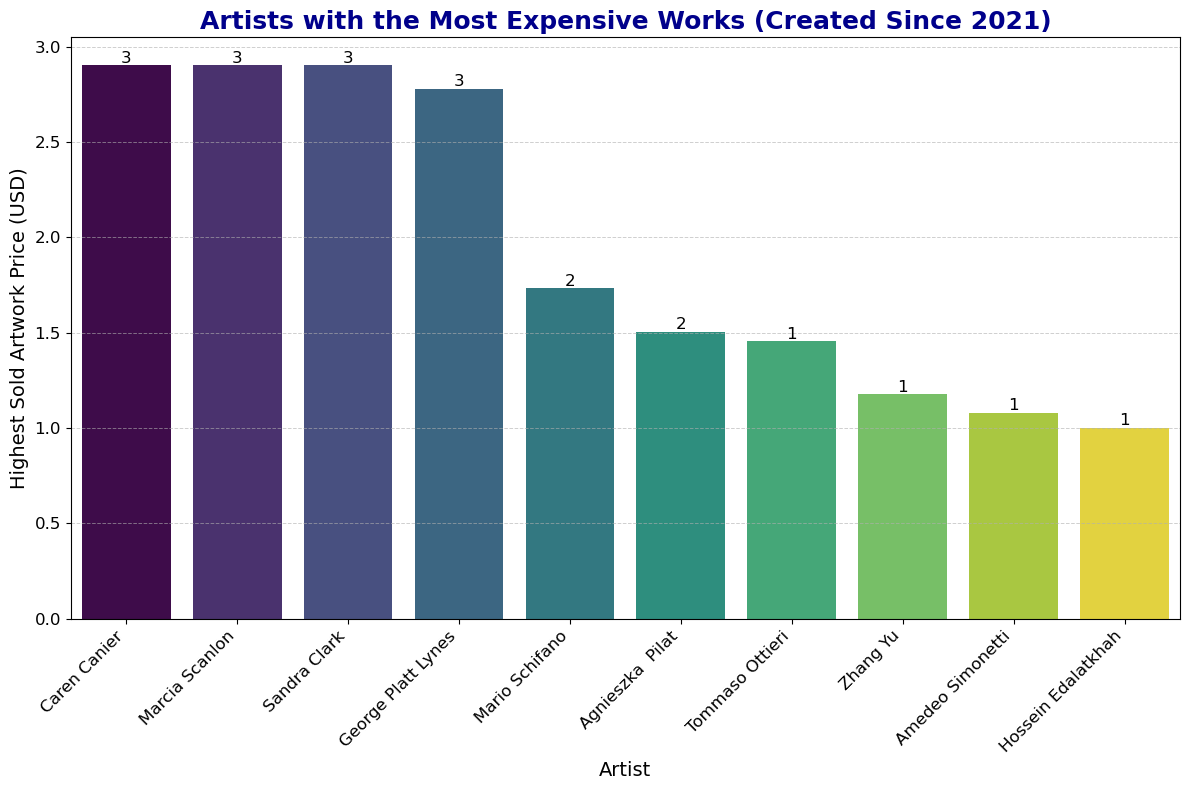

In [24]:
# Plotando o gráfico de barras
plt.figure(figsize=(12, 8))  # Tamanho maior para mais detalhes

# Gerar um gradiente de cores baseado no preço
norm = plt.Normalize(vmin=top_10_expensive_artists.min(), vmax=top_10_expensive_artists.max())
cmap = plt.cm.viridis  # Usar o colormap 'viridis'

# Gráfico de barras com cor personalizada (degrade)
ax = sns.barplot(x=top_10_expensive_artists.index, 
                 y=np.log10(top_10_expensive_artists.values),
                 palette=cmap(np.linspace(0, 1, len(top_10_expensive_artists))))

# Customize title and axis labels
plt.title('Artists with the Most Expensive Works (Created Since 2021)', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Artist', fontsize=14, fontweight='medium', color='black')
plt.ylabel('Highest Sold Artwork Price (USD)', fontsize=14, fontweight='medium', color='black')

# Melhorar a visibilidade das barras
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adicionar linhas de grade horizontais para melhor leitura dos valores
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Adicionar valores em cima das barras com formatação de milhares
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',  # Formatar o valor como número com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Localização do texto
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')  # Ajuste do texto

# Exibir o gráfico com layout ajustado
plt.tight_layout()
plt.show()

#log pyplot.semilogy(*args, **kwargs)

C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\2011571517.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='price', data=dataset, palette='viridis')


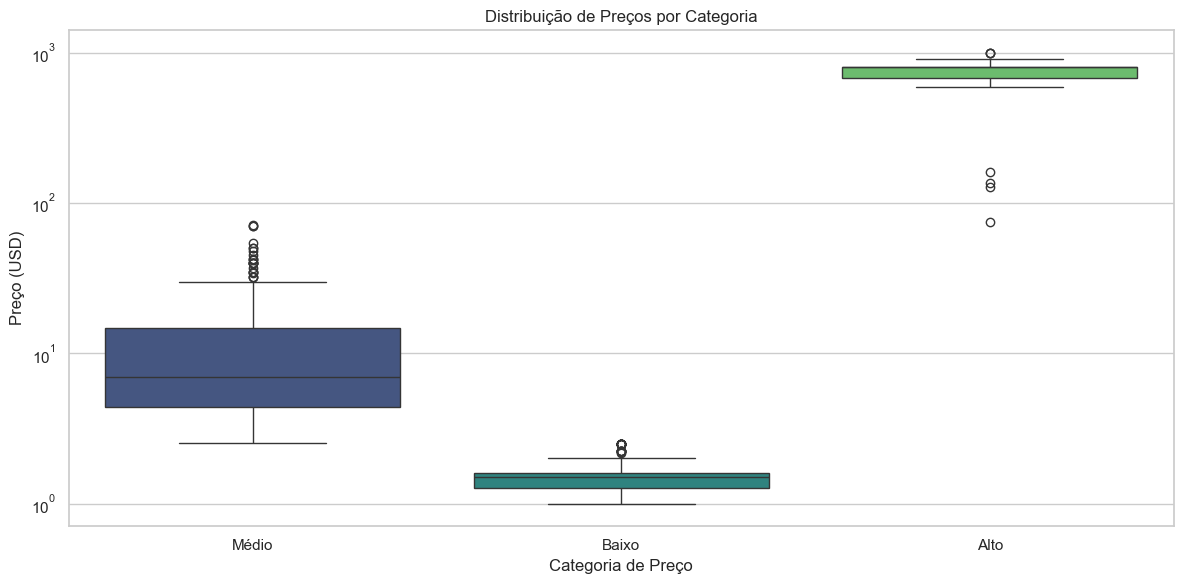


Estatísticas Descritivas por Categoria de Preço e Período:
                             count        mean   median         std
price_category period                                              
Alto           Contemporary     81  709.728395  680.000  148.688770
               Modern            9  666.666667  680.000   63.245553
               Post-War         99  800.202020  800.000   49.414527
Baixo          19th Century      1    2.250000    2.250         NaN
               Contemporary     97    1.604536    1.500    0.458847
               Modern           11    1.707273    1.875    0.380909
               Post-War         91    1.590220    1.500    0.298389
               [nan]             1    1.500000    1.500         NaN
Médio          19th Century     11   11.686364   10.000    9.566611
               Contemporary    236   12.890975    9.500   11.419155
               Modern           22    7.240909    6.250    4.932102
               Post-War         95    8.467474    5.000 

C:\Users\pietr\AppData\Local\Temp\ipykernel_13856\2011571517.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Resultados dos Testes de Diferença de Preços entre Períodos:
Contemporary vs Post-War:
  p-valor: 0.0000
  Significativo: Sim

Contemporary vs Modern:
  p-valor: 0.9911
  Significativo: Não

Contemporary vs 19th Century:
  p-valor: 0.1012
  Significativo: Não

Contemporary vs [nan]:
  p-valor: 0.6125
  Significativo: Não

Post-War vs Modern:
  p-valor: 0.0284
  Significativo: Sim

Post-War vs 19th Century:
  p-valor: 0.0145
  Significativo: Sim

Post-War vs [nan]:
  p-valor: 0.4634
  Significativo: Não

Modern vs 19th Century:
  p-valor: 0.0957
  Significativo: Não

Modern vs [nan]:
  p-valor: 0.6050
  Significativo: Não

19th Century vs [nan]:
  p-valor: 0.3631
  Significativo: Não



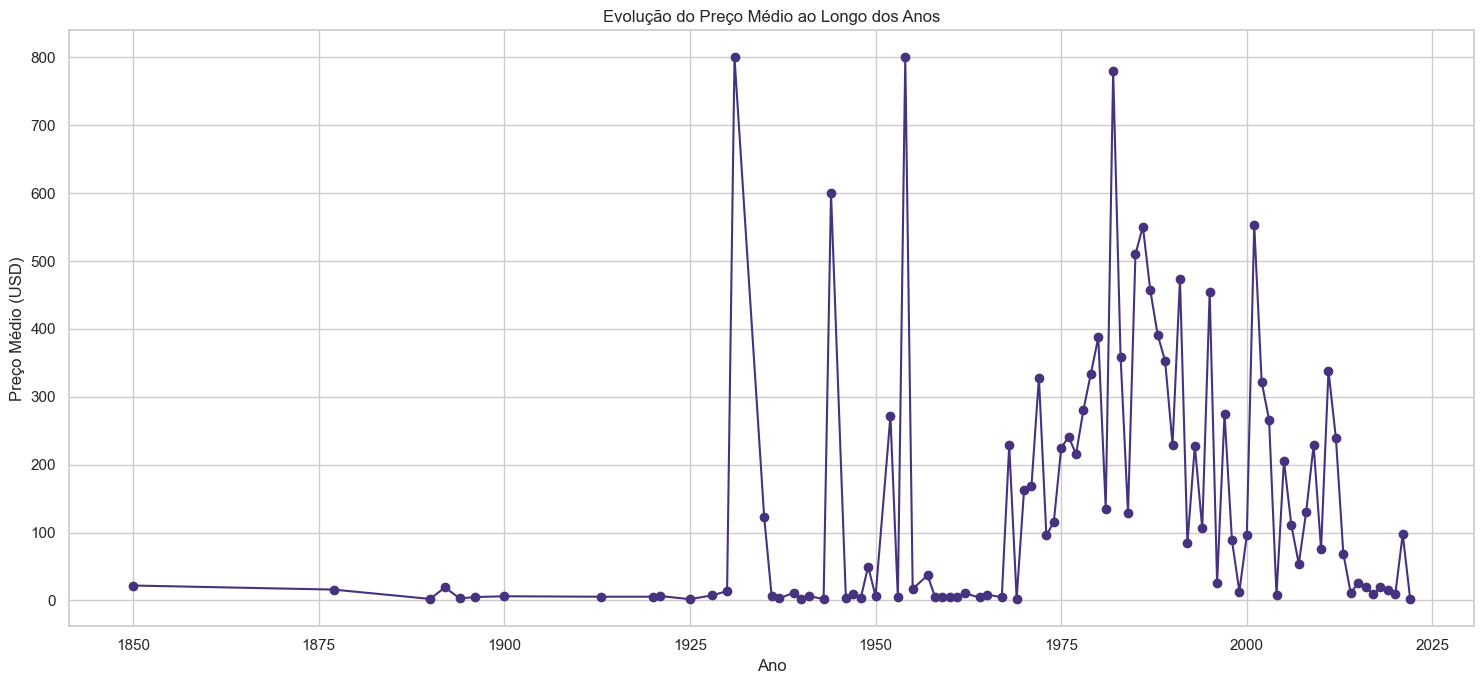


Análise Concluída!


In [32]:
# 1. Tratamento de Outliers e Criação de Categorias de Preço
def categorizar_preco(preco):
    """
    Categoriza os preços em níveis:
    - Baixo: abaixo do 25º percentil
    - Médio: entre 25º e 75º percentil
    - Alto: acima do 75º percentil
    """
    percentis = dataset['price'].quantile([0.25, 0.75])
    if preco <= percentis[0.25]:
        return 'Baixo'
    elif preco <= percentis[0.75]:
        return 'Médio'
    else:
        return 'Alto'

# Adicionar coluna de categoria de preço
dataset['price_category'] = dataset['price'].apply(categorizar_preco)

# 2. Análise de Correlação entre Variáveis Numéricas
# Converter yearCreation para numérico, tratando erros
dataset['yearCreation'] = pd.to_numeric(dataset['yearCreation'], errors='coerce')

# Selecionar apenas colunas numéricas para correlação
colunas_numericas = ['price', 'yearCreation']

# Calcular matriz de correlação
correlation_matrix = dataset[colunas_numericas].corr()


# 3. Análise de Distribuição de Preços por Categoria
plt.figure(figsize=(12, 6))
sns.boxplot(x='price_category', y='price', data=dataset, palette='viridis')
plt.title('Distribuição de Preços por Categoria')
plt.xlabel('Categoria de Preço')
plt.ylabel('Preço (USD)')
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.tight_layout()
plt.show()

# 4. Análise Estatística Descritiva por Categoria de Preço e Período
stats_por_categoria = dataset.groupby(['price_category', 'period'])['price'].agg([
    'count',   # Número de obras
    'mean',    # Preço médio
    'median',  # Preço mediano
    'std'      # Desvio padrão
])
print("\nEstatísticas Descritivas por Categoria de Preço e Período:")
print(stats_por_categoria)

# 5. Visualização de Dispersão Avançada
plt.figure(figsize=(15, 10))
scatter = sns.scatterplot(
    data=dataset, 
    x='yearCreation', 
    y='price', 
    hue='condition',  # Cor baseada na condição
    size='price',     # Tamanho baseado no preço
    sizes=(20, 200),  # Intervalo de tamanhos
    alpha=0.7,
    palette='deep'
)

plt.title('Dispersão de Preços: Ano de Criação vs Condição', fontsize=15)
plt.xlabel('Ano de Criação', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.yscale('log')  # Escala logarítmica
plt.tight_layout()
plt.show()

# 6. Teste de Hipótese: Diferença Significativa de Preços entre Períodos
from scipy import stats

# Exemplo: Testar se há diferença significativa de preços entre períodos
periodos_unicos = dataset['period'].unique()
resultados_teste = {}

for i in range(len(periodos_unicos)):
    for j in range(i+1, len(periodos_unicos)):
        periodo1 = periodos_unicos[i]
        periodo2 = periodos_unicos[j]
        
        precos_periodo1 = dataset[dataset['period'] == periodo1]['price']
        precos_periodo2 = dataset[dataset['period'] == periodo2]['price']
        
        # Teste t de Student
        t_statistic, p_value = stats.ttest_ind(precos_periodo1, precos_periodo2)
        
        resultados_teste[(periodo1, periodo2)] = {
            't_statistic': t_statistic, 
            'p_value': p_value
        }

print("\nResultados dos Testes de Diferença de Preços entre Períodos:")
for (periodo1, periodo2), resultado in resultados_teste.items():
    print(f"{periodo1} vs {periodo2}:")
    print(f"  p-valor: {resultado['p_value']:.4f}")
    print(f"  Significativo: {'Sim' if resultado['p_value'] < 0.05 else 'Não'}\n")

# 7. Análise de Séries Temporais Simplificada
# Agregar preços médios por ano
precos_por_ano = dataset.groupby('yearCreation')['price'].mean()

plt.figure(figsize=(15, 7))
precos_por_ano.plot(kind='line', marker='o')
plt.title('Evolução do Preço Médio ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Preço Médio (USD)')
plt.tight_layout()
plt.show()

print("\nAnálise Concluída!")